In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import lightkurve as lk

In [9]:
#just setting up sample data
search_result = lk.search_targetpixelfile('Pi Mensae', mission='TESS', sector=1)
tpf = search_result.download(quality_bitmask='default')


In [26]:
def plotperiodograph(targetpixelfile):
    #This is the mask from lightkurve for the aperture
    aperture = targetpixelfile.pipeline_mask
    
    #This is a postage stamp x and y values for pixels that are part of the aperture
    postagestamp = np.where(aperture == True)
    
    #Setting up the pixel subplots so They create a rectangle of pixels based off the min and max of the row and column values from the aperture mask.
    #Could make ploting functions optional for the user and set this to default
    fig,ax = plt.subplots(len(np.arange(postagestamp[0].min(),postagestamp[0].max()+1)),
                      len(np.arange(postagestamp[1].min(),postagestamp[1].max()+1)),
                      figsize=(20,20),sharex='col', sharey='row')

    #Just making the subplot spacings 0 pixel width and height separation
    fig.subplots_adjust(wspace=0,hspace=0)
    
    
    #iterating through the columns of the postage stamp pixels
    for i in np.arange(postagestamp[0].min(),postagestamp[0].max()+1):
    
        #iterating through the rows of the postage stamp pixels
        for j in np.arange(postagestamp[1].min(),postagestamp[1].max()+1):
        
            #Creating a false mask to alter each iteration
            mask = np.zeros((len(aperture),len(aperture[0])), dtype=bool)
            
            #setting one pixel in the postage stamp to have a lightcurve extracted and plotted
            mask[i][j] = True
        
            #extracting the light curve for the target pixel
            
            lightcurve = targetpixelfile.to_lightcurve(aperture_mask=mask)
            #lightcurve = lightcurve[lightcurve.quality==0]
            periodogram = lightcurve.to_periodogram(oversample_factor=5)
                                  
        
            #Plotting the target pixel periodograph -- This can also be set up to have looks based on user input if desired
            ax[i-postagestamp[0].min()][j-postagestamp[1].min()].plot(periodogram.frequency,periodogram.power);
            #ax[i-postagestamp[0].min()][j-postagestamp[1].min()].set_yscale('log')

    

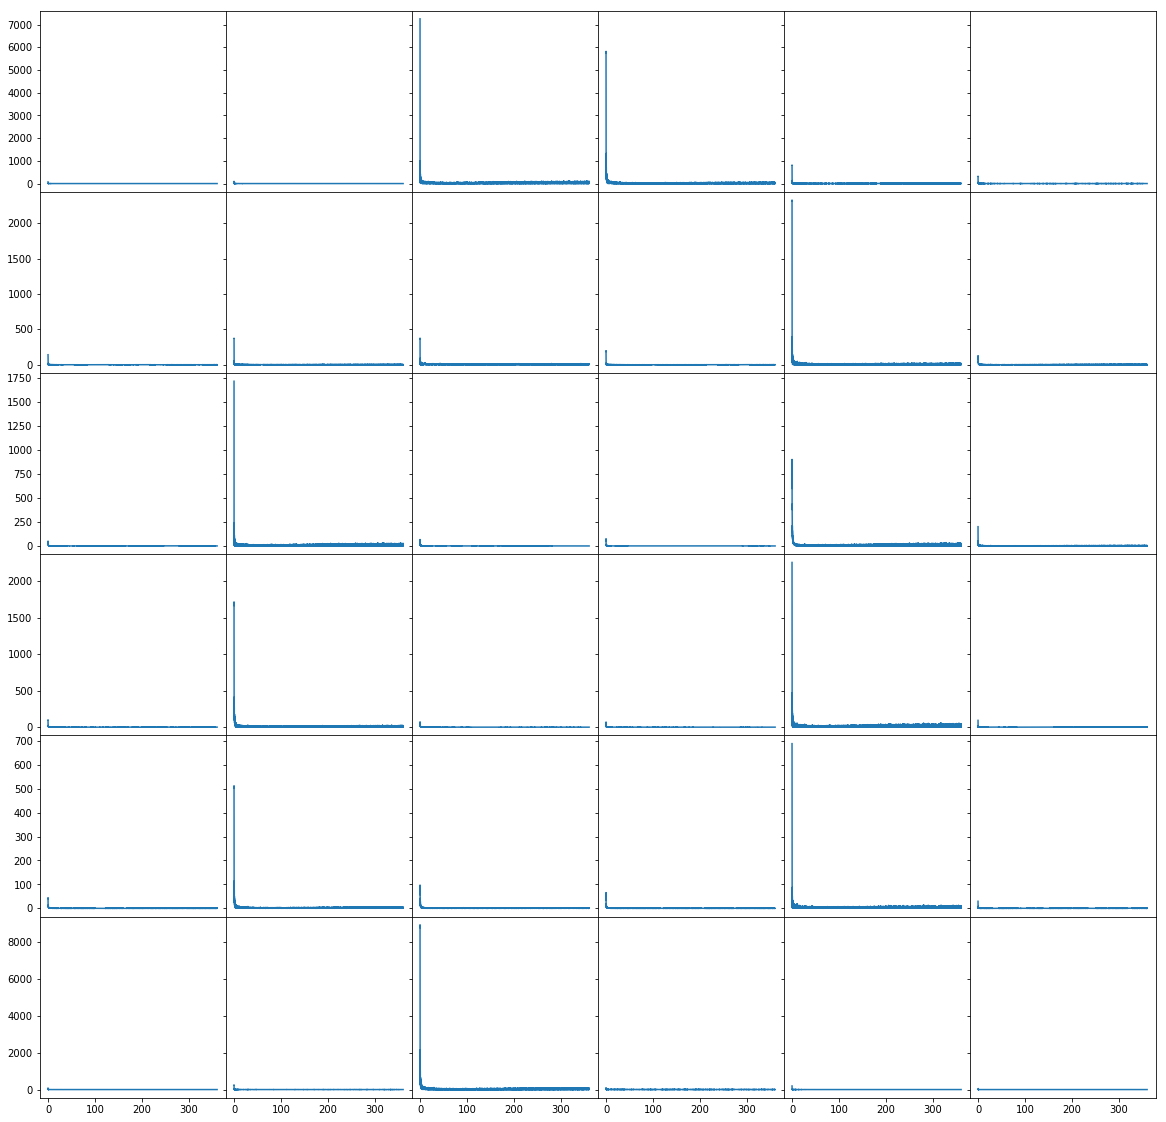

In [27]:
plotperiodograph(tpf);

1. Generalized way to convert each pixel into a light curve.
2. apply tpf mask to that (bool in def : true,false) to get desired pixels to graph
3. Make a periodogram for each relevant pixel
4. Graph that nicely.

Class for the periodograph data/array
Pass kwargs through

Normalization
x-xmin / (xmax -xmin)

<Quantity [7.17357402e-03, 1.43471480e-02, 2.15207221e-02, ...,
           3.59991465e+02, 3.59998639e+02, 3.60005812e+02] 1 / d>